In [223]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, Subset
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting
import nilearn
from glob import glob
import audtorch
from audtorch.metrics.functional import pearsonr

from sklearn.metrics import roc_auc_score


In [224]:
model_name = 'ss-forecast2'
data = np.load('/data/agelgazzar/projects/state-spaces/outputs/{}.npz'.format(model_name))
outputs = data['output']
target = data['target']
inputs = data['input']


In [225]:
inputs.shape

(2911, 490, 118)

In [226]:
mask_rois = np.array(np.load('/data/agelgazzar/projects/state-spaces/ho_networks.npy', allow_pickle=True).item()['Frotoparital'])


In [227]:
normal_args = np.arange(0,1000)
anomaly_args = np.arange(1000,2000)
normal_outputs = outputs[normal_args].transpose(0,2,1)
normal_targets = target[normal_args].transpose(0,2,1)
anomaly_outputs = outputs[anomaly_args].transpose(0,2,1)
anomaly_targets = target[anomaly_args].transpose(0,2,1)
normal_inputs = inputs[normal_args].transpose(0,2,1)
anomal_inputs = inputs[anomaly_args].transpose(0,2,1)

In [228]:
def calculate_score(data):
    
    X = data['output'].transpose(0,2,1)
    Y = data['target'].transpose(0,2,1)
    #Z = data['y']

    
    mses = []
    corrs = []
    diff = []
    maes = [] 
    
    for (x,y) in zip(X, Y):
        
        x = torch.tensor(x)
        y = torch.tensor(y)
        corr = np.abs(pearsonr(x,y).numpy())#.mean()
        corr = corr.mean()
        mse = torch.mean(torch.square(torch.subtract(x,y)),axis=1).numpy().mean()
        mae = torch.mean(torch.abs(torch.subtract(x,y)),axis=1).numpy().mean()

        corrs.append(corr)
        mses.append(mse)
        maes.append(mae)
        diff.append(-corr)
    return mses, maes, corrs, diff


    
    
 
    

In [229]:
mses, maes, corrs, diff = calculate_score(data)


In [230]:
def calculate_score_roi(data,roi):
    
    X = data['output'].transpose(0,2,1)[:,roi,:]
    Y = data['target'].transpose(0,2,1)[:,roi,:]
    Z = data['y']

    
    mses = []
    corrs = []
    diff = []
    maes = [] 
    
    for (x,y) in zip(X, Y):
        
        x = torch.tensor(x)
        y = torch.tensor(y)
        corr = np.abs(pearsonr(x,y).numpy()).mean()
        mse = torch.mean(torch.square(torch.subtract(x,y))).numpy().mean()
        mae = torch.mean(torch.abs(torch.subtract(x,y))).numpy().mean()

        corrs.append(corr)
        mses.append(mse)
        maes.append(mae)
        diff.append(corr-mse)
    return mses, maes, corrs, diff,  Z


    
    
 
    

In [304]:
idx = 28


target_sample_a = anomaly_targets[idx]
output_sample_a = anomaly_outputs[idx]
input_sample_a = anomal_inputs[idx]

target_sample_n = normal_targets[idx]
output_sample_n = normal_outputs[idx]
input_sample_n = normal_inputs[idx]


x_a = torch.tensor(output_sample_a)
y_a = torch.tensor(target_sample_a)

x_n = torch.tensor(output_sample_n)
y_n = torch.tensor(target_sample_n)


corrs_a = np.abs(pearsonr(x_a,y_a).numpy())
corrs_n = np.abs(pearsonr(x_n,y_n).numpy())

mse_a = torch.mean(torch.square(torch.subtract(x_a,y_a)),axis=1).numpy()
mse_n = torch.mean(torch.square(torch.subtract(x_n,y_n)),axis=1).numpy()

#print(corrs_a.mean(), corrs_n.mean())
print(mse_a.mean(), mse_n.mean())


#print(corrs_a.mean() - mse_a.mean() , corrs_n.mean() - mse_n.mean())

0.13309297 0.23698486


In [305]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split= True)
labels_cor = dataset.labels[1:]
dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm', symmetric_split= True)
ho_sub = dataset.maps
labels_sub = dataset.labels[1:]

regions = np.array(labels_cor+labels_sub)


In [306]:
tn = np.empty_like(input_sample_n)
on = np.empty_like(input_sample_n)
ta = np.empty_like(input_sample_n)
oa= np.empty_like(input_sample_n)

oa[:,:440] = None
oa[:,440:] = output_sample_a

ta[:,:440] = None
ta[:,440:] = target_sample_a

on[:,:440] = None
on[:,440:] = output_sample_n

tn[:,:440] = None
tn[:,440:] = target_sample_n


input_sample_n[:,-50:] = None
input_sample_a[:,-50:] = None


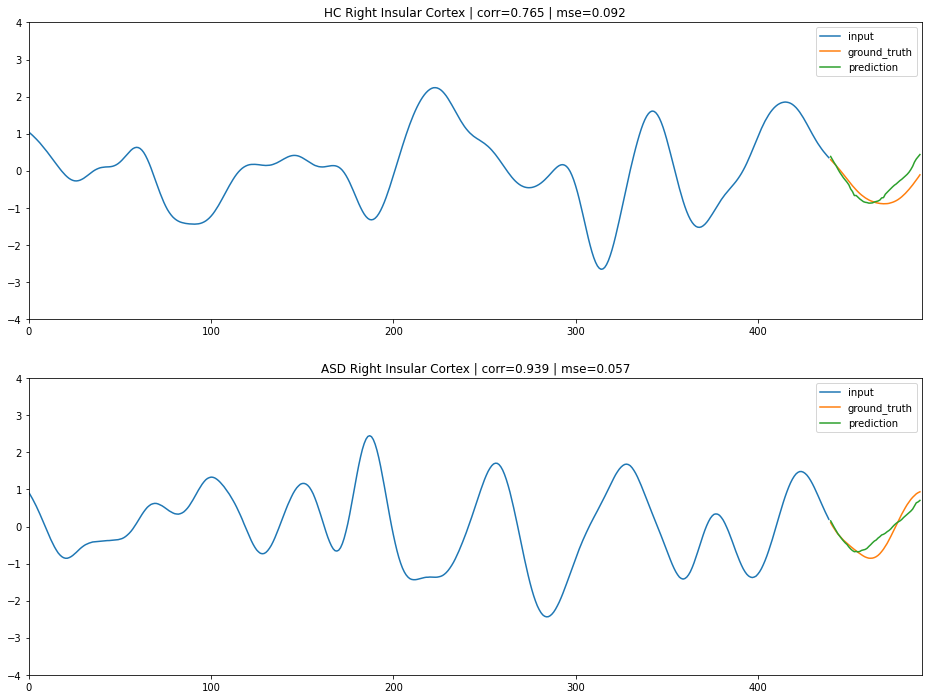

In [234]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
ind = 3
roi = ind#mask_rois[ind]
custom_xlim = (0, 490)
custom_ylim = (-4, 4)
plt.setp(ax[0], xlim=custom_xlim, ylim=custom_ylim)
plt.setp(ax[1], xlim=custom_xlim, ylim=custom_ylim)

#plot_subject(ax[0], input_sample, roi)
ax[0].set_title('HC '+ regions[roi] + ' | corr={:.3f} | mse={:.3f}'.format(corrs_n[ind][0],mse_n[ind]))
plot_subject(ax[0], input_sample_n, ind,  name='input')
plot_subject(ax[0], tn, ind, name='ground_truth')
plot_subject(ax[0], on, ind,  name='prediction')
ax[0].legend(loc='best')


ax[1].set_title('ASD '+regions[roi] + ' | corr={:.3f} | mse={:.3f}'.format(corrs_a[ind][0],mse_a[ind]))
plot_subject(ax[1], input_sample_a, ind,  name='input')
plot_subject(ax[1], ta, ind, name='ground_truth')
plot_subject(ax[1], oa, ind, name='prediction')
ax[1].legend(loc='best')

#plt.savefig('/data/agelgazzar/projects/state-spaces/samples/asd_default_{}_subj2.png'.format(roi))


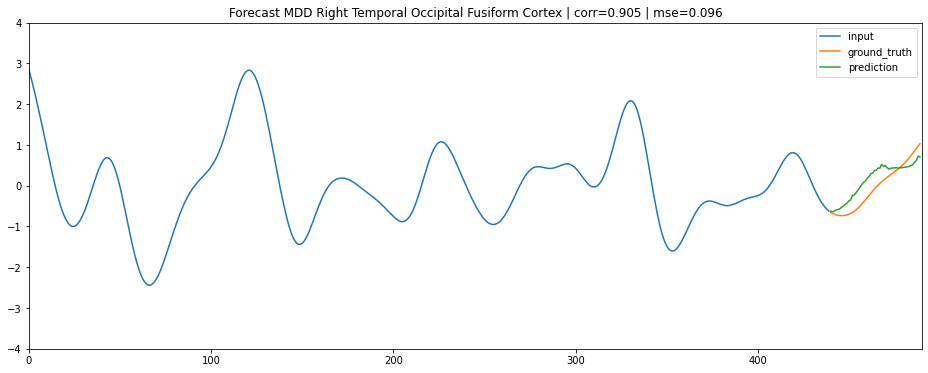

In [311]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
ind = 77
roi = ind #mask_rois[ind]
custom_xlim = (0, 490)
custom_ylim = (-4, 4)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

#plot_subject(ax[0], input_sample, roi)
ax.set_title('Forecast MDD '+ regions[roi] + ' | corr={:.3f} | mse={:.3f}'.format(corrs_a[ind][0],mse_a[ind]))
plot_subject(ax, input_sample_a, ind,  name='input')
plot_subject(ax, ta, ind, name='ground_truth')
plot_subject(ax, oa, ind,  name='prediction')
ax.legend(loc='best')
plt.savefig('/data/agelgazzar/projects/state-spaces/samples/forecast_{}_mdd.png'.format(roi))


In [12]:
def plot_subject(ax, subject, roi=-1, name='ground_truth'):
    if roi == -1:
        for region in subject:
            ax.plot(region)
    else:
        for region in subject[roi:roi+1]:
            ax.plot(region, label=name)

In [ ]:
np.arange(0,116,2)

In [ ]:
batches = glob('./outputs/*')

for batch in batches:
    batch = np.load(batch)
    target = np.transpose(batch['target'],(0,2,1))
    output = np.transpose(batch['output'],(0, 2,1))
    for y_, y in (zip(output,target)):
        
    

In [ ]:
batches = glob('./outputs/*')

preds = []
targets = []


for batch in batches:
    batch = np.load(batch)
    targets.append(np.transpose(batch['target'],(0,2,1)))
    preds.append(np.transpose(batch['output'],(0, 2,1)))

preds = np.concatenate(preds,axis=0)
targets = np.concatenate(targets,axis=0)


In [ ]:
preds = np.transpose(ouptut['output'],(0,2,1))
targets = np.transpose(ouptut['target'], (0,2,1))

In [ ]:
targets.shape

In [ ]:
rois_mse = np.mean(np.square(np.subtract(targets,preds)),axis=0)
rois_mse_mean = np.mean(rois_mse,axis=1)
rois_mse_sd = np.std(rois_mse,axis=1)

In [ ]:
sort_inds = np.argsort(rois_mse_mean)
rois_mse_sorted_m = rois_mse_mean[sort_inds]
rois_mse_sorted_sd = rois_mse_sd[sort_inds]

regions = np.array(regions)
rois_sorted = regions[sort_inds]

In [ ]:
sort_inds

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16,30))

# Example data
y_pos = np.arange(len(rois_sorted))
#plt.rcParams.update({'font.size': 22})
ax.barh(rois_sorted, rois_mse_sorted_m, xerr=rois_mse_sorted_sd)
ax.set_yticks(y_pos, labels=rois_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('MSE error')
ax.set_title('ROIs forecasting errors')

plt.savefig('rois_errors_t=50.pdf', dpi=1000)

In [ ]:
#df_h = pd.read_csv('csvfiles/ukbb_MDD_train.csv')

c = 0
for i in range(len(df_h)):
    tc = df_h['tc_file'].iloc[i].replace('ATLAS','HO')
    if not os.path.isfile(tc):
        print(tc)


In [ ]:
df_h = df_h[df_h.ID != 1641691]

In [ ]:
a = np.load("outputs/abide_linear.npy")
a.shape

In [ ]:
import numpy as np
from nilearn import plotting

plotting.plot_matrix(a, figure=(10, 8))

In [ ]:
hc_nodes = np.argsort(a.sum(axis=0))

In [ ]:
np.diagonal(a)

In [ ]:
np.sum(a,axis=1)

In [ ]:
mask_rois

In [ ]:
a[69].argmax()

In [ ]:
regions[hc_nodes]